In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Step 1: Define paths and categories
features_dir = 'audio_features'
labels_dir = 'labels'
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Step 2: Load metadata
metadata = pd.read_csv('metadata.csv')
file_names = metadata['filename']

# Step 3: Load features and labels
X = []
y = []

for file in file_names:
    feature_path = os.path.join(features_dir, file.replace('.wav', '.npy'))
    label_path = os.path.join(labels_dir, file.replace('.wav', '.txt'))
    
    # Skip if missing files
    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        continue
    
    # Load feature and label
    feature = np.load(feature_path)
    with open(label_path, 'r') as f:
        label = f.read().strip()
    
    # Only keep examples with valid labels
    if label not in categories:
        continue

    X.append(feature)
    y.append(categories.index(label))  # Convert label to integer

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Step 4: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [3]:
import pandas as pd

df = pd.read_csv("metadata.csv")
print("Number of rows:", len(df))


Number of rows: 1000


In [15]:
import numpy as np
import pandas as pd
import os
import itertools
from sklearn.model_selection import train_test_split

# Define categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Paths
features_dir = 'audio_features'
labels_dir = 'labels'

# Read metadata
metadata = pd.read_csv('metadata.csv')
file_names = metadata['filename'].tolist()

# Aggregate frame labels into single labels
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if sum(frame_labels) == 0:
            __y.append([0])
        elif np.count_nonzero(frame_labels) == len(frame_labels):
            __y.append([1])
        else:  # Annotators don't agree
            __y.append([np.random.choice(frame_labels)])
    return __y

# Read features and labels
def read_files(file_names, num_to_read=1000):
    X_train = []
    Y_train = {c: [] for c in categories}
    
    for f in file_names[:num_to_read]:
        base_name = f.split('.')[0]
        feature_path = os.path.join(features_dir, base_name + '.npz')
        label_path = os.path.join(labels_dir, base_name + '_labels.npz')

        if not os.path.exists(feature_path) or not os.path.exists(label_path):
            continue

        features = np.load(feature_path)["embeddings"]
        X_train.append(features)

        y = np.load(label_path)
        for c in categories:
            if c in y:
                _y = aggregate_labels(y[c])
                Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
            else:
                # If a category is missing, assume it's not present
                Y_train[c].extend([0] * features.shape[0])

    X_train = np.concatenate(X_train, axis=0)
    return X_train, Y_train

# Load data
X, Y_dict = read_files(file_names, num_to_read=1000)

# Example: convert labels for a single class (e.g. 'Dog Bark') to binary classification
# You can extend this to train a One-vs-Rest model for all classes
target_class = 'Dog Bark'
y = np.array(Y_dict[target_class])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Loaded samples for class '{target_class}': {len(X)}")
print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")


Loaded samples for class 'Dog Bark': 184754
Train set: 147803, Test set: 36951


In [7]:
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
import numpy as np

# Assuming you already have:
# X_train, X_test, y_train, y_test from your split
# and y_pred from your model's predictions on X_test



# Baseline: predict majority class from training data
majority_class = Counter(y_train).most_common(1)[0][0]
baseline_preds = np.full_like(y_test, fill_value=majority_class)

# Baseline metrics
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_macro_f1 = f1_score(y_test, baseline_preds, average='macro')

print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline macro F1-score: {baseline_macro_f1:.4f}")

# Model performance (replace y_pred with your predictions)
# y_pred = model.predict(X_test) or similar
# macro_f1 = f1_score(y_test, y_pred, average='macro')
# print(f"Model Macro F1-score: {macro_f1:.4f}")


Baseline accuracy: 0.9831
Baseline macro F1-score: 0.4957


In [8]:
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you already have:
# X, Y_dict from read_files(file_names, num_to_read=1000)
# and categories list defined

# Convert Y_dict to multi-label matrix Y (samples x categories)
labels_list = [np.array(Y_dict[c]) for c in categories]
Y = np.vstack(labels_list).T  # shape: (num_samples, num_categories)

# Split data (no stratify for multilabel)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=None
)

# For baseline metrics: calculate per category majority class and metrics
for i, c in enumerate(categories):
    y_train_cat = Y_train[:, i]
    y_test_cat = Y_test[:, i]

    # Find majority class in training labels for this category
    majority_class = Counter(y_train_cat).most_common(1)[0][0]

    # Predict majority class for all test samples in this category
    baseline_preds = np.full_like(y_test_cat, fill_value=majority_class)

    # Calculate baseline accuracy and macro F1-score per category
    baseline_acc = accuracy_score(y_test_cat, baseline_preds)
    baseline_macro_f1 = f1_score(y_test_cat, baseline_preds, average='macro')

    print(f"Category: {c}")
    print(f"  Baseline Accuracy: {baseline_acc:.4f}")
    print(f"  Baseline Macro F1-score: {baseline_macro_f1:.4f}")
    print()


Category: Airplane
  Baseline Accuracy: 0.9942
  Baseline Macro F1-score: 0.4985

Category: Alarm
  Baseline Accuracy: 0.9979
  Baseline Macro F1-score: 0.4995

Category: Beep/Bleep
  Baseline Accuracy: 0.9911
  Baseline Macro F1-score: 0.4978

Category: Bell
  Baseline Accuracy: 0.9893
  Baseline Macro F1-score: 0.4973

Category: Bicycle
  Baseline Accuracy: 0.9991
  Baseline Macro F1-score: 0.4998

Category: Bird Chirp
  Baseline Accuracy: 0.9589
  Baseline Macro F1-score: 0.4895

Category: Bus
  Baseline Accuracy: 0.9892
  Baseline Macro F1-score: 0.4973

Category: Car
  Baseline Accuracy: 0.9638
  Baseline Macro F1-score: 0.4908

Category: Cat Meow
  Baseline Accuracy: 0.9986
  Baseline Macro F1-score: 0.4997

Category: Chainsaw
  Baseline Accuracy: 1.0000
  Baseline Macro F1-score: 1.0000

Category: Clapping
  Baseline Accuracy: 0.9839
  Baseline Macro F1-score: 0.4959

Category: Cough
  Baseline Accuracy: 0.9744
  Baseline Macro F1-score: 0.3290

Category: Cow Moo
  Baseline Accu

In [10]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import itertools
import os

# Your categories list
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Assuming features_dir and labels_dir are defined, and file_names is a list of filenames

def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if sum(frame_labels) == 0:
            __y.append([0])
        elif np.count_nonzero(frame_labels) == len(frame_labels):
            __y.append([1])
        else:  # Annotators don't agree
            __y.append([np.random.choice(frame_labels)])
    return __y

def read_files(file_names, num_to_read=1000):
    X_all = []
    Y_all = {c: [] for c in categories}
    
    for f in file_names[:num_to_read]:
        base_name = f.split('.')[0]
        feature_path = os.path.join(features_dir, base_name + '.npz')
        label_path = os.path.join(labels_dir, base_name + '_labels.npz')

        if not os.path.exists(feature_path) or not os.path.exists(label_path):
            continue

        features = np.load(feature_path)["embeddings"]
        X_all.append(features)

        y = np.load(label_path)
        for c in categories:
            if c in y:
                _y = aggregate_labels(y[c])
                Y_all[c].extend(list(itertools.chain.from_iterable(_y)))
            else:
                Y_all[c].extend([0] * features.shape[0])

    X_all = np.concatenate(X_all, axis=0)
    return X_all, Y_all

# Load all data
X, Y_dict = read_files(file_names, num_to_read=1000)

# Convert label dict to numpy array: samples x categories
Y = np.column_stack([np.array(Y_dict[c]) for c in categories])

# Split data and labels simultaneously
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y[:, 0]  # Stratify by first category for example
)

# Compute baseline predictions per category
baseline_preds = np.zeros_like(Y_test)
for i in range(len(categories)):
    majority_class = Counter(Y_train[:, i]).most_common(1)[0][0]
    baseline_preds[:, i] = majority_class

# Calculate accuracy and macro F1 per category
acc_per_category = []
f1_per_category = []

for i in range(len(categories)):
    acc = accuracy_score(Y_test[:, i], baseline_preds[:, i])
    f1 = f1_score(Y_test[:, i], baseline_preds[:, i], average='macro', zero_division=0)
    acc_per_category.append(acc)
    f1_per_category.append(f1)

# Average across categories
baseline_accuracy = np.mean(acc_per_category)
baseline_macro_f1 = np.mean(f1_per_category)

print(f"Baseline accuracy (all categories averaged): {baseline_accuracy:.4f}")
print(f"Baseline macro F1-score (all categories averaged): {baseline_macro_f1:.4f}")


Baseline accuracy (all categories averaged): 0.9801
Baseline macro F1-score (all categories averaged): 0.5441


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming Y is your label array with shape (num_samples, num_categories)
# If you used the previous code, Y is np.column_stack([labels for all categories])

# Flatten all labels into one 1D array
all_labels_flat = Y.flatten()

# Find the majority class in all labels combined
from collections import Counter
majority_class = Counter(all_labels_flat).most_common(1)[0][0]

# Create baseline predictions - predict the majority class for all samples *and categories*
baseline_preds_flat = np.full_like(all_labels_flat, fill_value=majority_class)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(all_labels_flat, baseline_preds_flat)

print(f"Baseline classifier predicts majority class ({majority_class}) for all labels.")
print(f"Baseline accuracy: {baseline_accuracy:.4f}")


Baseline classifier predicts majority class (0.0) for all labels.
Baseline accuracy: 0.9801


In [14]:
from sklearn.metrics import f1_score
import numpy as np

# Assume Y_test is your ground truth, shape (n_samples, n_classes)
# Let's create dummy predictions (all zeros) of the same shape
y_pred = np.zeros_like(Y_test)

# Confirm shape and type
print("Y_test shape:", Y_test.shape)
print("y_pred shape:", y_pred.shape)

# Compute macro F1 score for multilabel classification
macro_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)

print(f"Macro F1-score: {macro_f1:.4f}")


Y_test shape: (36951, 58)
y_pred shape: (36951, 58)


ValueError: Classification metrics can't handle a mix of multiclass-multioutput and multilabel-indicator targets

    max_depth  min_samples_split criterion  f1_score
23        NaN                 10   entropy  0.494975
21        NaN                  5   entropy  0.494975
19        NaN                  2   entropy  0.494975
17       10.0                 10   entropy  0.494975
7         5.0                  2   entropy  0.494975
15       10.0                  5   entropy  0.494975
9         5.0                  5   entropy  0.494975
13       10.0                  2   entropy  0.494975
11        5.0                 10   entropy  0.494975
1         3.0                  2   entropy  0.493983
3         3.0                  5   entropy  0.493983
5         3.0                 10   entropy  0.493983
0         3.0                  2      gini  0.493405
4         3.0                 10      gini  0.493405
2         3.0                  5      gini  0.493405
6         5.0                  2      gini  0.490830
10        5.0                 10      gini  0.490621
8         5.0                  5      gini  0.

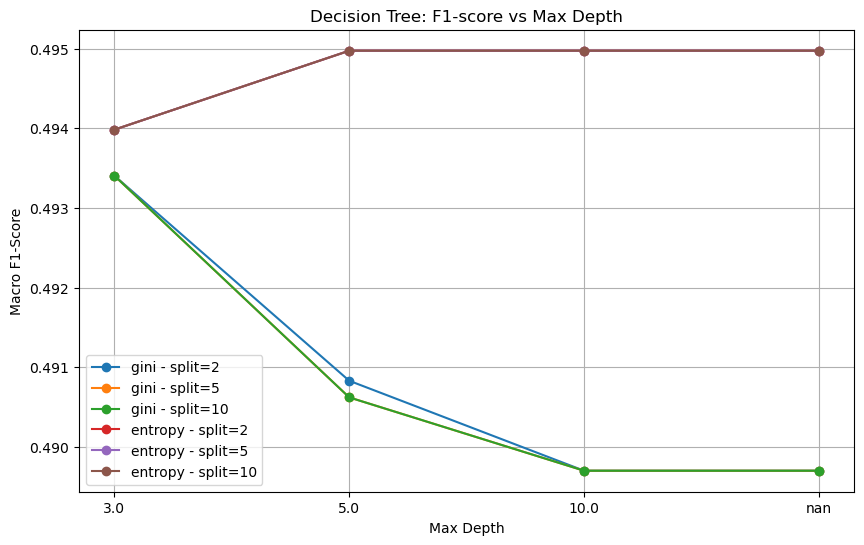

In [20]:
import numpy as np
import os
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Define categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
    'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
    'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
    'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
    'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
    'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
    'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Load metadata
metadata = pd.read_csv('metadata.csv')
all_files = metadata["filename"].tolist()

features_dir = 'audio_features'
labels_dir = 'labels'

# Load file labels (aggregated over frames)
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if sum(frame_labels) == 0:
            __y.append([0])
        elif np.count_nonzero(frame_labels) == len(frame_labels):
            __y.append([1])
        else:
            __y.append([np.random.choice(frame_labels)])
    return __y

def read_files(file_names, num_to_read=1000):
    X_data = []
    Y_data = {c: [] for c in categories}
    for f in file_names[:num_to_read]:
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_data.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_data[c].extend(list(itertools.chain.from_iterable(_y)))
    X_data = np.concatenate(X_data)
    return X_data, Y_data

# Split file names manually
train_filenames, testval_filenames = train_test_split(all_files, test_size=0.3, random_state=42)
val_filenames, test_filenames = train_test_split(testval_filenames, test_size=0.5, random_state=42)

# Load datasets
X_train, Y_train = read_files(train_filenames, 500)
X_val, Y_val = read_files(val_filenames, 100)
X_test, Y_test = read_files(test_filenames, 50)

# Subsample training
sample_size = 1000
indices = np.random.choice(len(X_train), size=sample_size, replace=False)
X_train = X_train[indices]
for c in categories:
    Y_train[c] = np.array(Y_train[c])[indices]

# Extract 'Wind' data
wind_x_train = X_train
wind_y_train = Y_train['Wind']
wind_x_val = X_val
wind_y_val = np.array(Y_val['Wind'])

# Evaluation function
def evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return f1_score(y_val, y_pred, average='macro')

# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Grid search and evaluation
results = []
for depth in param_grid['max_depth']:
    for split in param_grid['min_samples_split']:
        for crit in param_grid['criterion']:
            clf = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_split=split,
                criterion=crit,
                random_state=42
            )
            score = evaluate_model(clf, wind_x_train, wind_y_train, wind_x_val, wind_y_val)
            results.append({
                'max_depth': depth,
                'min_samples_split': split,
                'criterion': crit,
                'f1_score': score
            })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='f1_score', ascending=False))

# Visualization: F1-score by max_depth
plt.figure(figsize=(10, 6))
for crit in param_grid['criterion']:
    subset = results_df[results_df['criterion'] == crit]
    for split in param_grid['min_samples_split']:
        depths = subset[subset['min_samples_split'] == split]['max_depth'].astype(str).fillna('None')
        scores = subset[subset['min_samples_split'] == split]['f1_score']
        plt.plot(depths, scores, marker='o', label=f'{crit} - split={split}')
plt.xlabel('Max Depth')
plt.ylabel('Macro F1-Score')
plt.title('Decision Tree: F1-score vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
import os
import itertools

# 1. Define categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# 2. Load or assume X_train, X_val, X_test, Y_train, Y_val, Y_test are already loaded
# We'll build full-label arrays here

y_train = np.array([Y_train[c] for c in categories]).T
y_val = np.array([Y_val[c] for c in categories]).T
y_test = np.array([Y_test[c] for c in categories]).T

# 3. Train multi-output Decision Tree classifier
X = X_train
Y = y_train

base_clf = DecisionTreeClassifier(random_state=42)
br_clf = MultiOutputClassifier(base_clf)
br_clf.fit(X, Y)

# 4. Predict on validation set
Y_pred = br_clf.predict(X_val)

# 5. Evaluate using balanced accuracy per label
n_labels = y_val.shape[1]
balanced_accuracies = []

for i in range(n_labels):
    score = balanced_accuracy_score(y_val[:, i], Y_pred[:, i])
    balanced_accuracies.append(score)

# 6. Compute macro-average
balanced_accuracy_macro = np.mean(balanced_accuracies)

print("Macro-Averaged Balanced Accuracy across all categories:", balanced_accuracy_macro)


Macro-Averaged Balanced Accuracy across all categories: 0.7134515764713982


/Users/elinaungure/anaconda3/envs/mlpc2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elinaungure/anaconda3/envs/mlpc2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/elinaungure/anaconda3/envs/mlpc2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/elinaungure/anaconda3/envs/mlpc2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pa

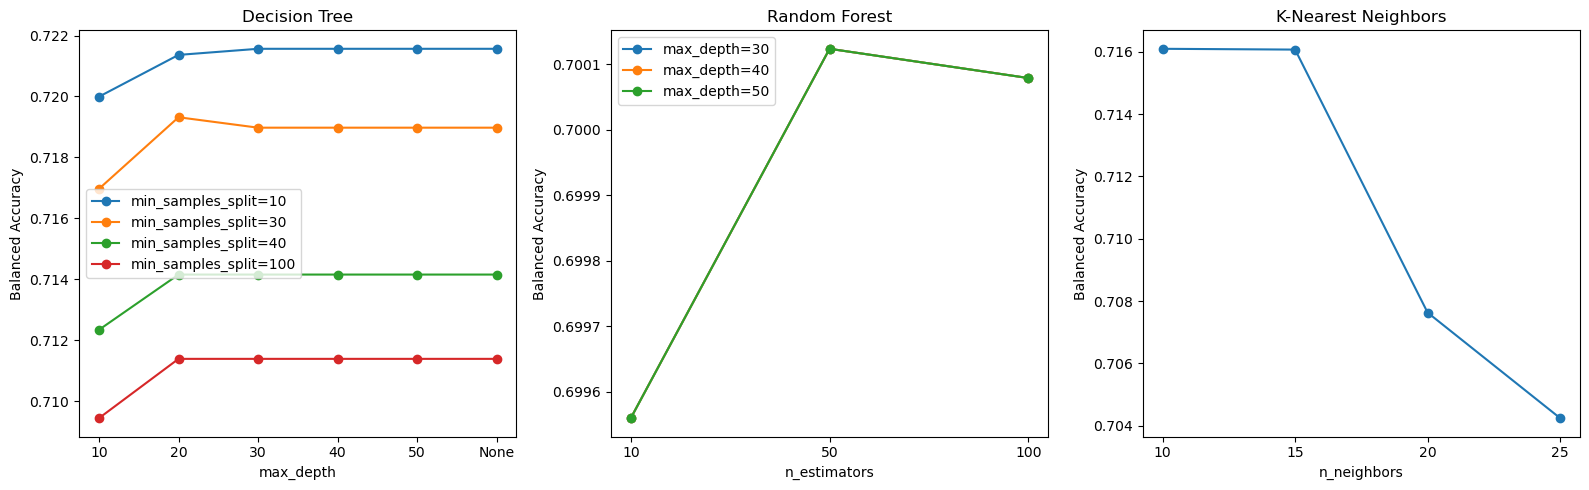

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define your categories (for multi-label classification)
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Ensure you have these already loaded:
# X_train, X_val, Y_train, Y_val

# Convert multi-label dictionaries to NumPy arrays
y_train = np.array([Y_train[c] for c in categories]).T
y_val = np.array([Y_val[c] for c in categories]).T

# Function to evaluate and store macro-averaged balanced accuracy
def evaluate_macro_accuracy(model, X_val, y_val):
    y_pred = model.predict(X_val)
    return np.mean([balanced_accuracy_score(y_val[:, i], y_pred[:, i]) for i in range(y_val.shape[1])])

results = {'DecisionTree': [], 'RandomForest': [], 'KNN': []}

# ===== Decision Tree =====
for max_depth in [10, 20, 30, 40, 50, None]:
    for min_samples_split in [10, 30, 40, 100]:
        clf = MultiOutputClassifier(
            DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['DecisionTree'].append({'max_depth': max_depth, 'min_samples_split': min_samples_split, 'score': score})

# ===== Random Forest =====
for n_estimators in [10, 50, 100]:
    for max_depth in [30, 40, 50]:
        clf = MultiOutputClassifier(
            RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['RandomForest'].append({'n_estimators': n_estimators, 'max_depth': max_depth, 'score': score})

# ===== K-Nearest Neighbors =====
for n_neighbors in [10, 15, 20, 25]:
    clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    clf.fit(X_train, y_train)
    score = evaluate_macro_accuracy(clf, X_val, y_val)
    results['KNN'].append({'n_neighbors': n_neighbors, 'score': score})

# ==== Plotting Function ====
def plot_results(results):
    plt.figure(figsize=(16, 5))

    # Decision Tree
    plt.subplot(1, 3, 1)
    for split in [10, 30, 40, 100]:
        scores = [r['score'] for r in results['DecisionTree'] if r['min_samples_split'] == split]
        labels = [str(r['max_depth']) for r in results['DecisionTree'] if r['min_samples_split'] == split]
        plt.plot(labels, scores, label=f'min_samples_split={split}', marker='o')
    plt.title("Decision Tree")
    plt.xlabel("max_depth")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # Random Forest
    plt.subplot(1, 3, 2)
    for depth in [30, 40, 50]:
        scores = [r['score'] for r in results['RandomForest'] if r['max_depth'] == depth]
        labels = [str(r['n_estimators']) for r in results['RandomForest'] if r['max_depth'] == depth]
        plt.plot(labels, scores, label=f'max_depth={depth}', marker='o')
    plt.title("Random Forest")
    plt.xlabel("n_estimators")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # KNN
    plt.subplot(1, 3, 3)
    scores = [r['score'] for r in results['KNN']]
    labels = [str(r['n_neighbors']) for r in results['KNN']]
    plt.plot(labels, scores, marker='o')
    plt.title("K-Nearest Neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("Balanced Accuracy")

    plt.tight_layout()
    plt.show()

plot_results(results)


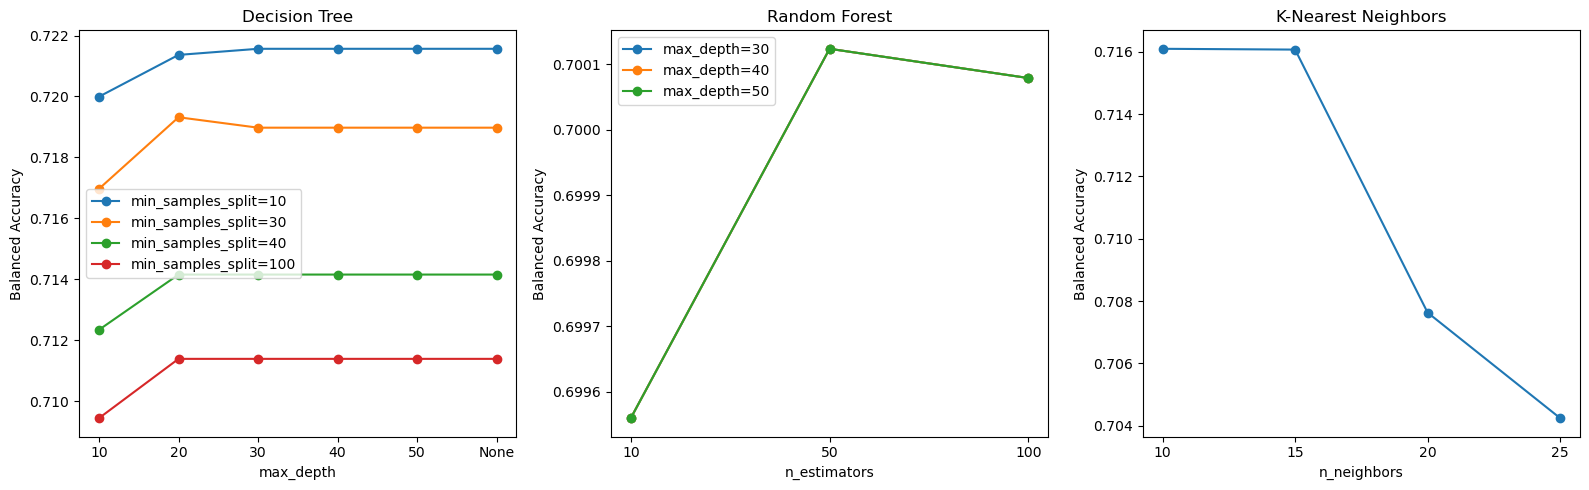

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score

# Define categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Convert multi-label dictionaries to NumPy arrays
y_train = np.array([Y_train[c] for c in categories]).T
y_val = np.array([Y_val[c] for c in categories]).T

# Evaluation function
def evaluate_macro_accuracy(model, X_val, y_val):
    y_pred = model.predict(X_val)
    return np.mean([balanced_accuracy_score(y_val[:, i], y_pred[:, i]) for i in range(y_val.shape[1])])

results = {'DecisionTree': [], 'RandomForest': [], 'KNN': []}

# ===== Decision Tree =====
for max_depth in [10, 20, 30, 40, 50, None]:
    for min_samples_split in [10, 30, 40, 100]:
        clf = MultiOutputClassifier(
            DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['DecisionTree'].append({'max_depth': max_depth, 'min_samples_split': min_samples_split, 'score': score})

# ===== Random Forest =====
for max_depth in [30, 40, 50]:
    for n_estimators in [10, 50, 100]:
        clf = MultiOutputClassifier(
            RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['RandomForest'].append({'n_estimators': n_estimators, 'max_depth': max_depth, 'score': score})

# ===== K-Nearest Neighbors =====
for n_neighbors in [10, 15, 20, 25]:
    clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    clf.fit(X_train, y_train)
    score = evaluate_macro_accuracy(clf, X_val, y_val)
    results['KNN'].append({'n_neighbors': n_neighbors, 'score': score})

# ==== Plotting Function ====
def plot_results(results):
    plt.figure(figsize=(16, 5))

    # Decision Tree
    plt.subplot(1, 3, 1)
    for split in [10, 30, 40, 100]:
        scores = [r['score'] for r in results['DecisionTree'] if r['min_samples_split'] == split]
        labels = [str(r['max_depth']) for r in results['DecisionTree'] if r['min_samples_split'] == split]
        plt.plot(labels, scores, label=f'min_samples_split={split}', marker='o')
    plt.title("Decision Tree")
    plt.xlabel("max_depth")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # Random Forest
    plt.subplot(1, 3, 2)
    for depth in [30, 40, 50]:
        scores = [r['score'] for r in results['RandomForest'] if r['max_depth'] == depth]
        labels = [str(r['n_estimators']) for r in results['RandomForest'] if r['max_depth'] == depth]
        plt.plot(labels, scores, label=f'max_depth={depth}', marker='o')
    plt.title("Random Forest")
    plt.xlabel("n_estimators")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # KNN
    plt.subplot(1, 3, 3)
    scores = [r['score'] for r in results['KNN']]
    labels = [str(r['n_neighbors']) for r in results['KNN']]
    plt.plot(labels, scores, marker='o')
    plt.title("K-Nearest Neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("Balanced Accuracy")

    plt.tight_layout()
    plt.show()

# Plot
plot_results(results)


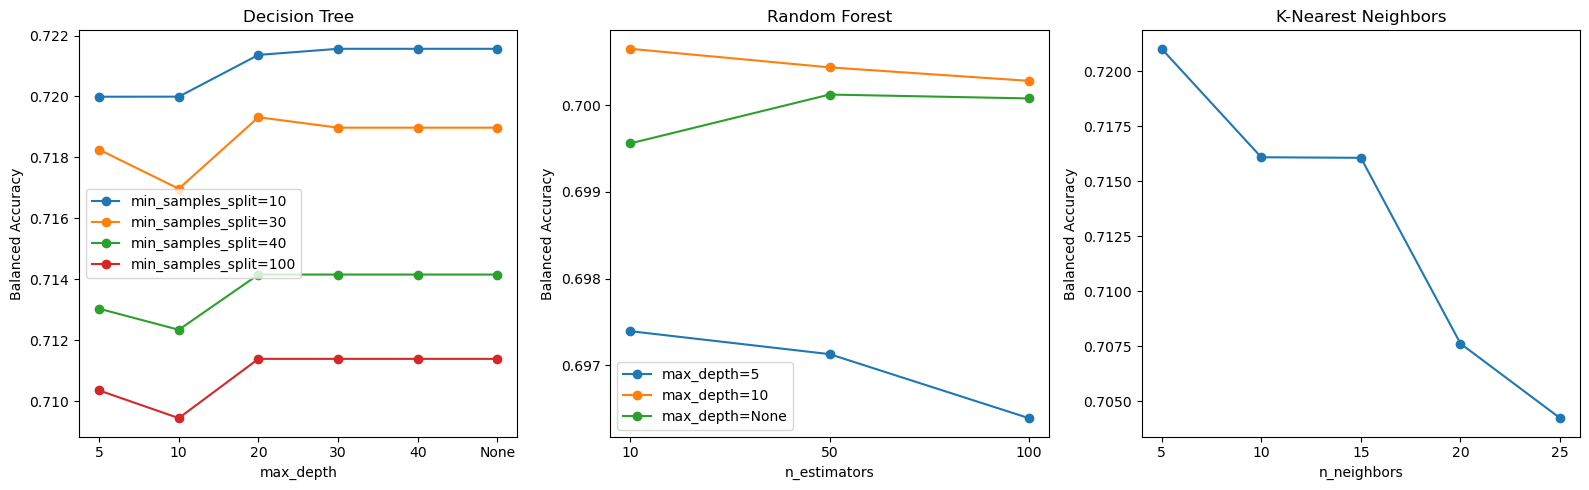

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score

# Define your categories (for multi-label classification)
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Ensure you have these already loaded:
# X_train, X_val, Y_train, Y_val

# Convert multi-label dictionaries to NumPy arrays
y_train = np.array([Y_train[c] for c in categories]).T
y_val = np.array([Y_val[c] for c in categories]).T

# Function to evaluate and store macro-averaged balanced accuracy
def evaluate_macro_accuracy(model, X_val, y_val):
    y_pred = model.predict(X_val)
    return np.mean([balanced_accuracy_score(y_val[:, i], y_pred[:, i]) for i in range(y_val.shape[1])])

results = {'DecisionTree': [], 'RandomForest': [], 'KNN': []}

# ===== Decision Tree =====
for max_depth in [5, 10, 20, 30, 40, None]:
    for min_samples_split in [10, 30, 40, 100]:
        clf = MultiOutputClassifier(
            DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['DecisionTree'].append({'max_depth': max_depth, 'min_samples_split': min_samples_split, 'score': score})

# ===== Random Forest =====
for n_estimators in [10, 50, 100]:
    for max_depth in [5, 10, None]:
        clf = MultiOutputClassifier(
            RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        )
        clf.fit(X_train, y_train)
        score = evaluate_macro_accuracy(clf, X_val, y_val)
        results['RandomForest'].append({'n_estimators': n_estimators, 'max_depth': max_depth, 'score': score})

# ===== K-Nearest Neighbors =====
for n_neighbors in [5, 10, 15, 20, 25]:
    clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=n_neighbors))
    clf.fit(X_train, y_train)
    score = evaluate_macro_accuracy(clf, X_val, y_val)
    results['KNN'].append({'n_neighbors': n_neighbors, 'score': score})

# ==== Plotting Function ====
def plot_results(results):
    plt.figure(figsize=(16, 5))

    # Decision Tree
    plt.subplot(1, 3, 1)
    for split in [10, 30, 40, 100]:
        scores = [r['score'] for r in results['DecisionTree'] if r['min_samples_split'] == split]
        labels = [str(r['max_depth']) for r in results['DecisionTree'] if r['min_samples_split'] == split]
        plt.plot(labels, scores, label=f'min_samples_split={split}', marker='o')
    plt.title("Decision Tree")
    plt.xlabel("max_depth")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # Random Forest
    plt.subplot(1, 3, 2)
    for depth in [5, 10, None]:
        scores = [r['score'] for r in results['RandomForest'] if r['max_depth'] == depth]
        labels = [str(r['n_estimators']) for r in results['RandomForest'] if r['max_depth'] == depth]
        plt.plot(labels, scores, label=f'max_depth={depth}', marker='o')
    plt.title("Random Forest")
    plt.xlabel("n_estimators")
    plt.ylabel("Balanced Accuracy")
    plt.legend()

    # KNN
    plt.subplot(1, 3, 3)
    scores = [r['score'] for r in results['KNN']]
    labels = [str(r['n_neighbors']) for r in results['KNN']]
    plt.plot(labels, scores, marker='o')
    plt.title("K-Nearest Neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("Balanced Accuracy")

    plt.tight_layout()
    plt.show()

plot_results(results)


In [33]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np

def evaluate_macro_accuracy(model, X_val, y_val):
    """
    Computes macro-averaged balanced accuracy for multi-label classification.

    Parameters:
    - model: Trained sklearn classifier wrapped in MultiOutputClassifier
    - X_val: Validation input features (2D array)
    - y_val: True labels for validation set (2D array of shape [n_samples, n_labels])

    Returns:
    - macro_avg_balanced_accuracy: Float, average of balanced accuracy across all labels
    """
    y_pred = model.predict(X_val)

    # Compute balanced accuracy for each label separately
    scores = [balanced_accuracy_score(y_val[:, i], y_pred[:, i]) for i in range(y_val.shape[1])]

    # Return the mean across all labels (macro-averaged)
    return np.mean(scores)


ValueError: object too deep for desired array

In [34]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import itertools
import os

# Define your categories
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
              'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
              'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
              'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
              'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
              'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
              'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

# Aggregation function
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if sum(frame_labels) == 0:
            __y.append([0])
        elif np.count_nonzero(frame_labels) == len(frame_labels):
            __y.append([1])
        else:
            __y.append([np.random.choice(frame_labels)])
    return __y

# Reading function
def read_files(file_names, num_to_read=1000):
    X_all = []
    Y_all = {c: [] for c in categories}
    
    for f in file_names[:num_to_read]:
        base_name = f.split('.')[0]
        feature_path = os.path.join(features_dir, base_name + '.npz')
        label_path = os.path.join(labels_dir, base_name + '_labels.npz')

        if not os.path.exists(feature_path) or not os.path.exists(label_path):
            continue

        features = np.load(feature_path)["embeddings"]
        X_all.append(features)

        y = np.load(label_path)
        for c in categories:
            if c in y:
                _y = aggregate_labels(y[c])
                Y_all[c].extend(list(itertools.chain.from_iterable(_y)))
            else:
                Y_all[c].extend([0] * features.shape[0])

    X_all = np.concatenate(X_all, axis=0)
    return X_all, Y_all

# Load the data
X, Y_dict = read_files(file_names, num_to_read=1000)
Y = np.column_stack([np.array(Y_dict[c]) for c in categories])

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y[:, 0]
)

# Create baseline predictions (most frequent label per class)
baseline_preds = np.zeros_like(Y_test)
for i in range(len(categories)):
    majority_class = Counter(Y_train[:, i]).most_common(1)[0][0]
    baseline_preds[:, i] = majority_class

# Compute macro-averaged balanced accuracy
balanced_accuracies = []
for i in range(len(categories)):
    score = balanced_accuracy_score(Y_test[:, i], baseline_preds[:, i])
    balanced_accuracies.append(score)

macro_balanced_accuracy = np.mean(balanced_accuracies)

print(f"Baseline Macro-Averaged Balanced Accuracy: {macro_balanced_accuracy:.4f}")


Baseline Macro-Averaged Balanced Accuracy: 0.5546


In [35]:
import numpy as np

# Assuming Y is a NumPy array of shape (n_samples, n_labels)
# And categories is your list of labels

label_frequencies = np.sum(Y, axis=0)  # Sum across all samples for each label
most_common_index = np.argmax(label_frequencies)
most_common_label = categories[most_common_index]
most_common_count = label_frequencies[most_common_index]

print(f"Most common class: '{most_common_label}' with {most_common_count} positive instances.")


Most common class: 'Speech' with 74754.0 positive instances.


In [36]:
print(f"Total number of samples: {Y.shape[0]}")


Total number of samples: 184754
